In [396]:
import praw
from praw.models import MoreComments
import pandas as pd
import numpy as np
import random
import re
from pmaw import PushshiftAPI
import datetime as dt
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [424]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

In [398]:
reddits = pd.read_csv('reddit_shows.csv')
reddits.columns = ['Show', 'Sub']
on_app = pd.read_csv('current_on_app.csv')
del on_app['Link']
on_app.columns = ['Date']
actives = pd.read_csv('Actives412.csv')
actives = actives.merge(on_app, how='right', on='Date')
actives = actives.T
actives.columns = actives.iloc[0]
actives = actives.iloc[1:]
actives.index = pd.to_datetime(actives.index)
for index in actives.index:
    converted = index.strftime('%M')
    if converted == '00':
        actives = actives.drop(index)

In [394]:
allactives = pd.read_csv('Actives412.csv')
allactives = allactives.T
allactives.columns = allactives.iloc[0]
allactives = allactives.iloc[1:]
allactives.index = pd.to_datetime(allactives.index)
for index in allactives.index:
    converted = index.strftime('%M')
    if converted == '00':
        allactives = allactives.drop(index)
allactives.sum().sort_values(ascending=False)

Date
Succession                      224773
The Mandalorian                 180333
Ted Lasso                       140464
Game of Thrones                 137615
TRH: New Jersey                 123826
The Last of Us                  107667
South Park                      107650
Breaking Bad                    107494
Survivor                        107165
The Bachelorette                106838
Yellowjackets                    93725
The Sopranos                     76788
Rick & Morty                     71435
The Walking Dead                 69609
The Boys                         67785
Dragonball Z                     67174
Stranger Things                  54318
House of the Dragon              52218
RHONJ                            46405
You                              43296
Grey's Anatomy                   42967
Star Trek: Picard                32556
Euphoria                         24645
Black Mirror                     17725
Invincible                       16596
Bridgerton          

In [340]:
agg_actives = actives.transpose()
agg_actives.head()

,2023-04-05 13:04:18,2023-04-05 13:16:24,2023-04-05 13:32:20,2023-04-05 13:53:47,2023-04-05 14:12:57,2023-04-05 14:13:56,2023-04-05 14:14:06,2023-04-05 14:15:07,2023-04-05 14:16:07,2023-04-05 18:31:42,...,2023-04-11 14:59:08,2023-04-11 17:08:04,2023-04-11 18:04:21,2023-04-11 22:05:56,2023-04-12 04:59:10,2023-04-12 10:59:08,2023-04-12 11:59:08,2023-04-12 14:59:08,2023-04-12 17:01:08,2023-04-12 18:45:05
Date,,,,,,,,,,,,,,,,,,,,,
Black Mirror,255,266,278,266,304,300,300,300,303,245,...,221,216,236,249,226,231,233,221,193,226
Bridgerton,167,167,144,135,133,130,130,129,128,120,...,94,143,172,267,65,80,97,60,104,110
Euphoria,366,361,327,365,327,341,341,346,346,345,...,376,390,315,343,185,302,290,224,411,329
Foundation,11,13,16,5,16,13,13,15,15,13,...,13,7,6,5,10,5,6,6,13,4
Grey's Anatomy,723,689,699,616,699,713,713,713,673,576,...,639,681,679,795,372,624,527,438,653,607


In [341]:
total_actives = []
for (colName, colData) in agg_actives.iteritems():
    total_actives.append(colData.sum())

/var/folders/3v/866x8bfs7hb47f11mt9d5vdc0000gn/T/ipykernel_10847/3473190053.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (colName, colData) in agg_actives.iteritems():


In [343]:
total_actives_df = pd.DataFrame(total_actives)
total_actives_df.columns = ['Total Actives']

In [358]:
import matplotlib.patheffects as path_effects


def add_median_labels(ax, fmt='.1f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y * 0.98, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])


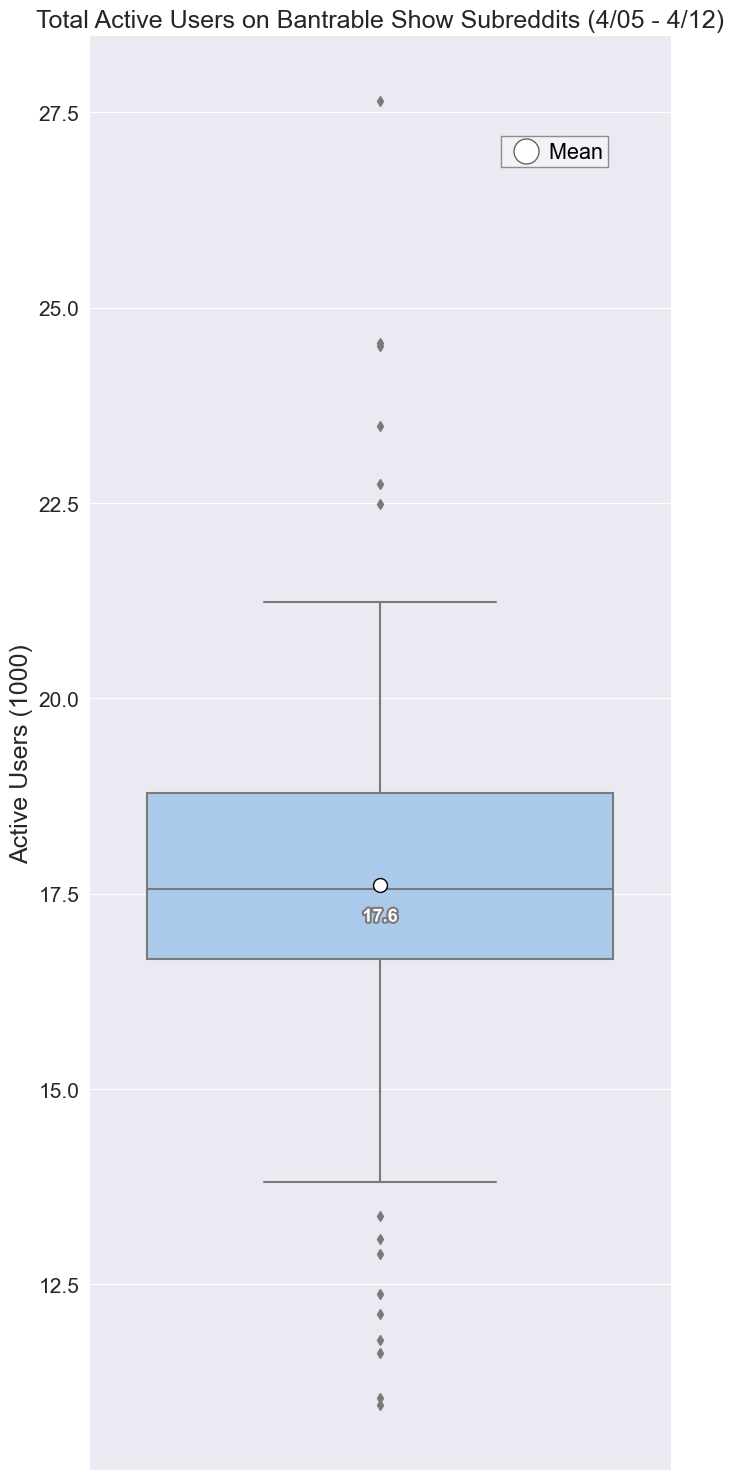

In [384]:
plt.figure(figsize=(7,15), tight_layout=True)
ax = sns.boxplot(y=total_actives_df['Total Actives']/1000,showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
ax.set(title='Total Active Users on Bantrable Show Subreddits (4/05 - 4/12)',ylabel='Active Users (1000)')
font = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 70,
        }
plt.text(0.3, 26.92, "       Mean", horizontalalignment='center', size='large', fontdict=font,bbox=dict(facecolor='white', edgecolor='black',alpha=0.4))
ax.plot(0.25,27, marker="o",
                       markerfacecolor="white", 
                       markeredgecolor="black",
                      markersize=18)
add_median_labels(ax)
plt.show()


<Axes: ylabel='Count'>

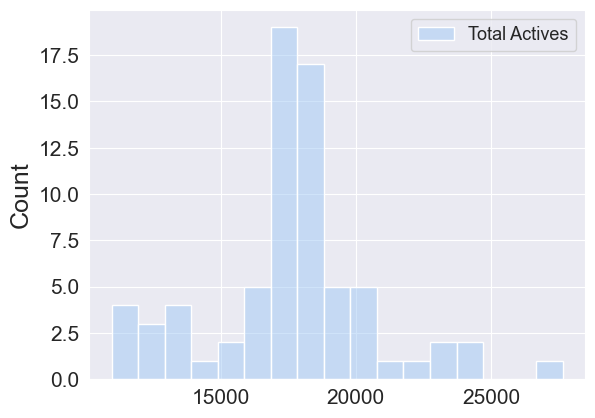

In [395]:
sns.histplot(data=total_actives_df)

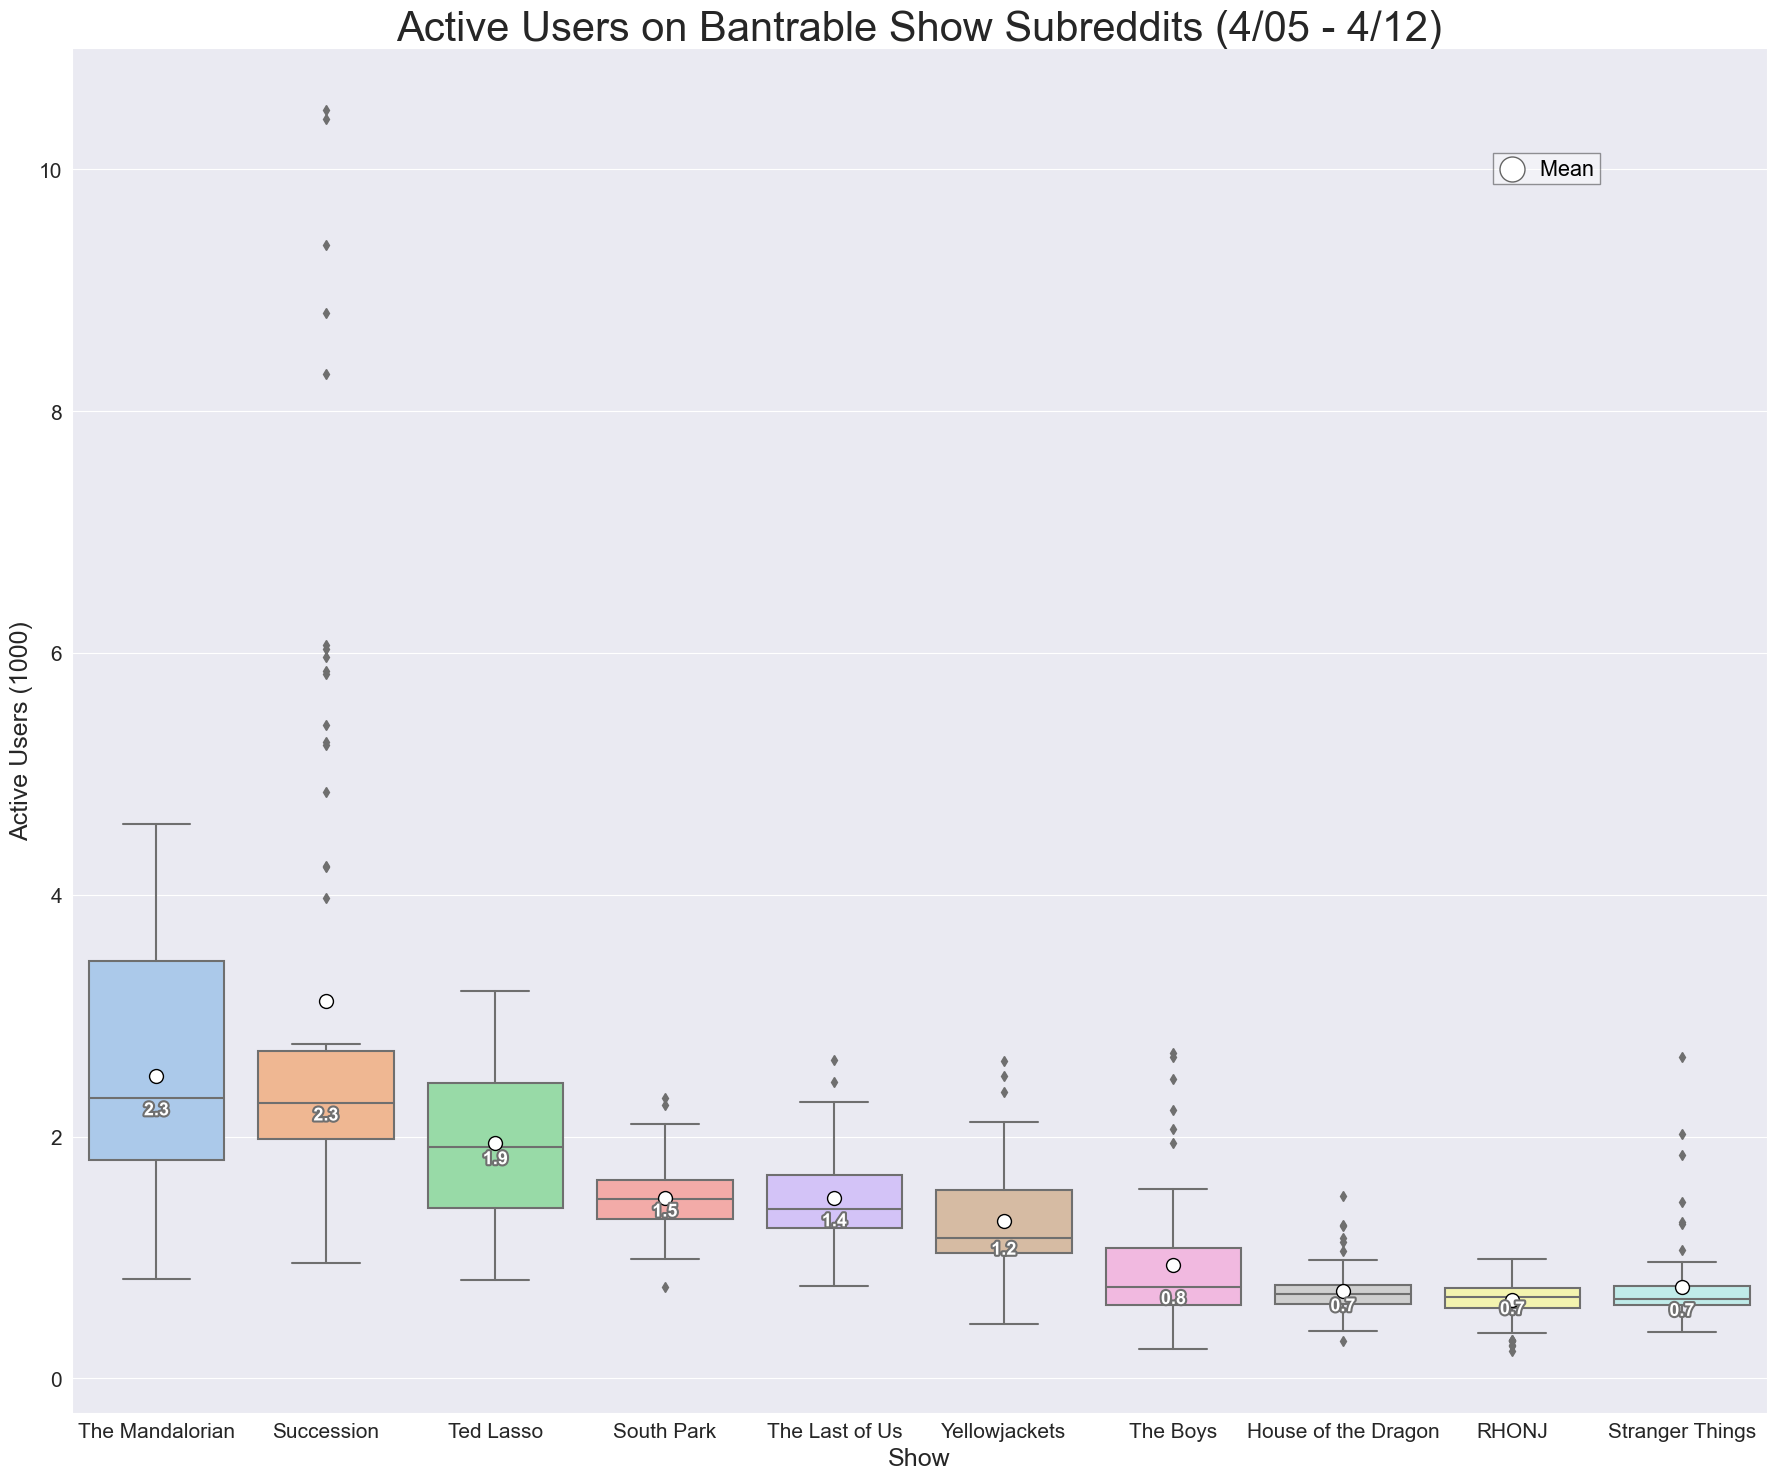

In [314]:
topactives = actives[['Succession',
 'The Mandalorian',
 'Ted Lasso',
 'The Last of Us',
 'South Park',
 'Yellowjackets',
 'The Boys',
 'Stranger Things',
 'House of the Dragon',
 'RHONJ',]]
median = topactives.median()
median.sort_values(ascending=False,inplace=True)
topactives = topactives[median.index]
topactives = topactives/1000
plt.figure(figsize=(18,15), tight_layout=True)
ax = sns.boxplot(data=topactives,showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
ax.set(title='Active Users on Bantrable Show Subreddits (4/05 - 4/12)',xlabel = 'Show', ylabel='Active Users (1000)')
font = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 70,
        }
plt.text(8.2, 9.955, "       Mean", horizontalalignment='center', size='large', fontdict=font,bbox=dict(facecolor='white', edgecolor='black',alpha=0.4))
ax.plot(8,10, marker="o",
                       markerfacecolor="white", 
                       markeredgecolor="black",
                      markersize=18)
add_median_labels(ax)
plt.show()

In [327]:
actives_mean = actives.sum()
mean_df = actives_mean.to_frame()
mean_df.columns = ['Total']
mean_df['Show'] = mean_df.index
mean_df = mean_df.sort_values(by=['Total'], ascending = False)
mean_df = mean_df.head(15)
mean_df['Total'] = pd.to_numeric(mean_df['Total'], downcast='float')
mean_df['Total'] = round(mean_df['Total']/100000,4)

Text(1.65, 14, 'Active Users -\nThe number of users who have\nviewed subreddit page in last hour\n\nMeasurements were taken approximately\nevery hour from 4/5 to 4/12')

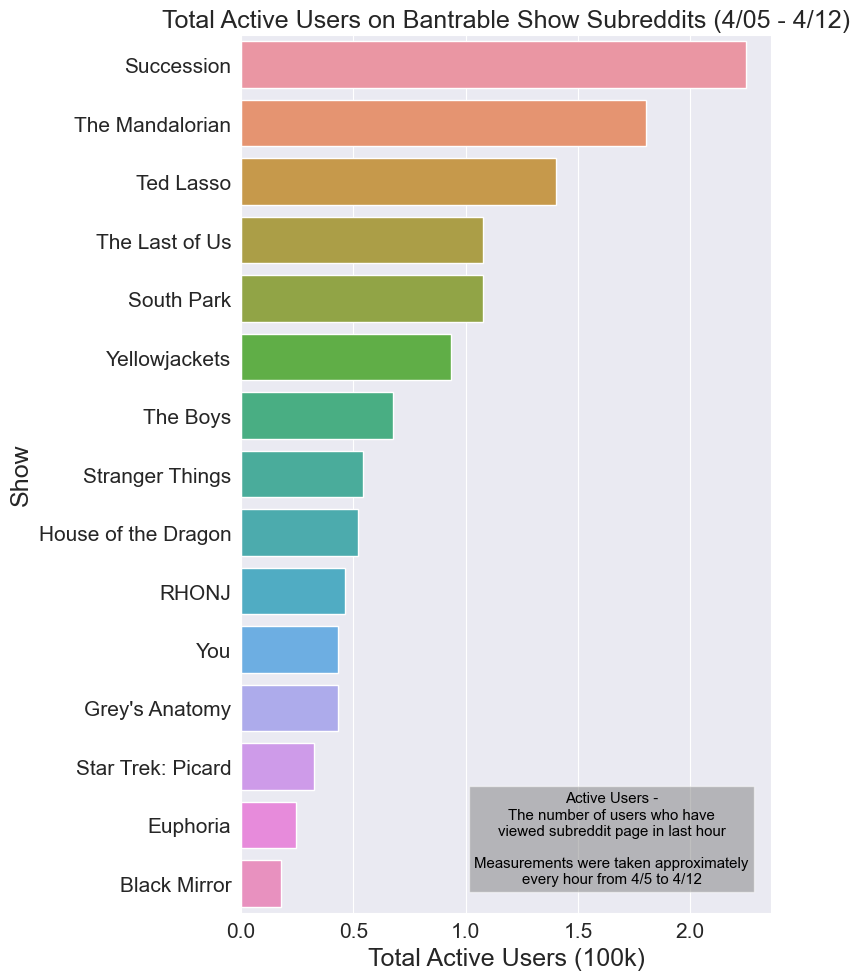

In [335]:
sns.set_palette('pastel')
font = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
plt.figure(figsize=(8,10), tight_layout=True)
ax = sns.barplot(x="Total", y=mean_df.index, data=mean_df)
ax.set(title='Total Active Users on Bantrable Show Subreddits (4/05 - 4/12)',xlabel = 'Total Active Users (100k)', ylabel='Show')
plt.text(1.65, 14, "Active Users -\nThe number of users who have\nviewed subreddit page in last hour\n\nMeasurements were taken approximately\nevery hour from 4/5 to 4/12", horizontalalignment='center', size='small', fontdict=font,bbox=dict(facecolor='grey', alpha=0.5))


In [161]:
maxdict = {'Show': [],'Max': [], 'Max Timestamp': []}
for col in actives.columns:
    maxdict['Show'].append(f'{col}')
    maxdict['Max Timestamp'].append(pd.to_numeric(actives[col]).idxmax())
    maxdict['Max'].append(actives[col].max())
max_df = pd.DataFrame.from_dict(maxdict)
max_df = max_df.sort_values(by=['Max'], ascending=False)

In [162]:
mindict = {'Show': [], 'Min': [], 'Min Timestamp': []}
for col in actives.columns:
    mindict['Show'].append(f'{col}')
    mindict['Min Timestamp'].append(pd.to_numeric(actives[col]).idxmin())
    mindict['Min'].append(actives[col].min())
min_df = pd.DataFrame.from_dict(mindict)
min_df = min_df.sort_values(by=['Min'], ascending=False)

In [197]:
max_min = max_df.merge(min_df, how='inner', on='Show')
total_df = mean_df.merge(max_min, how='inner', on='Show')
total_df['Max'] = round(total_df['Max']/1000,2)
total_df['Min'] = round(total_df['Min']/1000,2)


In [177]:
total_df

,Average,Show,Max,Max Timestamp,Min,Min Timestamp
0,3.10,Succession,10.49,2023-04-10 15:01:40,0.95,2023-04-07 06:00:51
1,2.46,The Mandalorian,4.59,2023-04-12 17:01:08,0.83,2023-04-11 18:04:21
2,1.93,Ted Lasso,3.20,2023-04-05 22:19:58,0.81,2023-04-08 04:04:08
3,1.51,The Last of Us,2.64,2023-04-06 20:00:51,0.76,2023-04-06 05:00:51
4,1.51,South Park,2.32,2023-04-06 19:59:07,0.75,2023-04-12 04:59:10


[Text(0.5, 1.0, 'Active Users on Bantrable Show Subreddits (4/05 - 4/12)'),
 Text(0.5, 0, 'Show'),
 Text(0, 0.5, 'Active Users (1000)')]

<Figure size 1000x800 with 0 Axes>

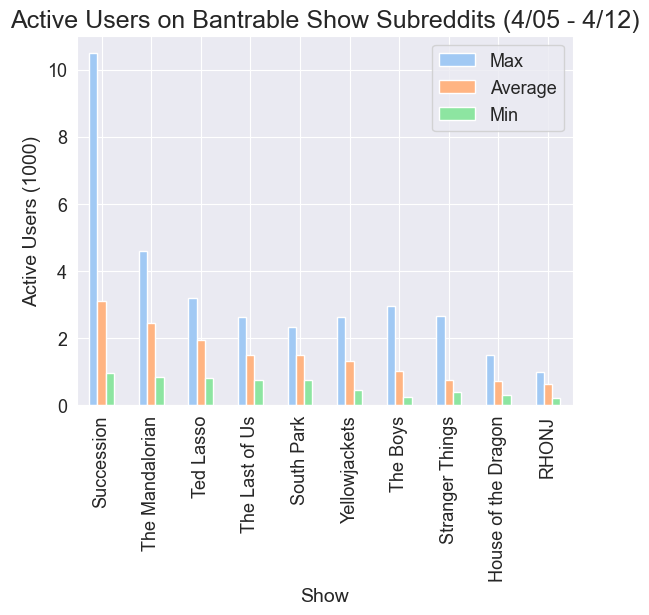

In [209]:
sns.set_palette('pastel')
font = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
plt.figure(figsize=(10,8), tight_layout=True)
ax = total_df.plot(x='Show', y=['Max', 'Average', 'Min'], kind='bar')
ax.set(title='Active Users on Bantrable Show Subreddits (4/05 - 4/12)',xlabel = 'Show', ylabel='Active Users (1000)')

[Text(0.5, 1.0, 'Active Users on Bantrable Show Subreddits (4/05 - 4/12)'),
 Text(0.5, 0, 'Show'),
 Text(0, 0.5, 'Active Users (1000)')]

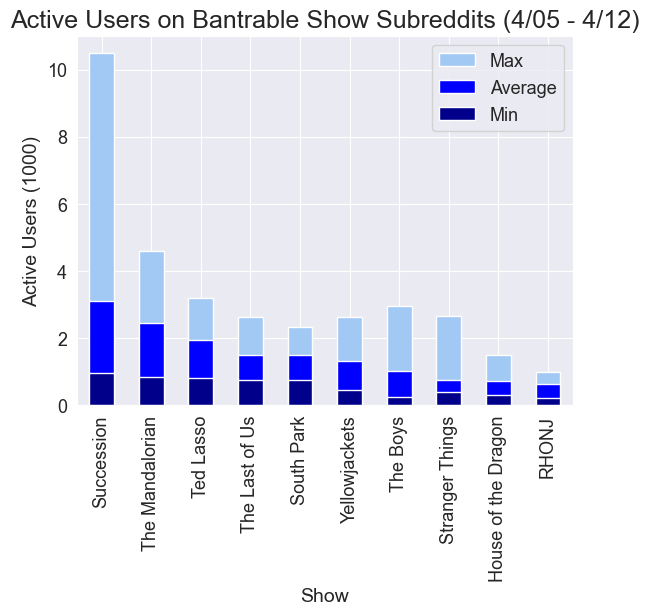

In [210]:
ax = total_df.plot(x='Show', y='Max', kind='bar')
total_df.plot(x='Show', y='Average', kind='bar', ax=ax, color='b')
total_df.plot(x='Show', y='Min', kind='bar', ax=ax, color='DarkBlue')
ax.set(title='Active Users on Bantrable Show Subreddits (4/05 - 4/12)',xlabel = 'Show', ylabel='Active Users (1000)')

In [400]:
actives['Day'] = actives.index.strftime('%A')

In [441]:
actives['Day'].value_counts()

Wednesday    21
Friday       15
Thursday     14
Tuesday       8
Sunday        6
Monday        5
Saturday      3
Name: Day, dtype: int64

In [442]:
weekactives = actives.groupby(['Day']).sum()

In [443]:
weekactives = pd.DataFrame(weekactives.sum(axis=1))

In [444]:
weekactives.columns = ['Total Active Users']

In [445]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekactives['Date'] = pd.Categorical(weekactives.index, categories=cats, ordered=True)
weekactives = weekactives.sort_values('Date')

In [446]:
weekactives['Total Active Users'] = weekactives['Total Active Users']/1000

[Text(0.5, 1.0, 'Total Weekly Active Users by Day (4/05 - 4/12)'),
 Text(0, 0.5, 'Active Users (1k)'),
 Text(0.5, 0, 'Day of Week')]

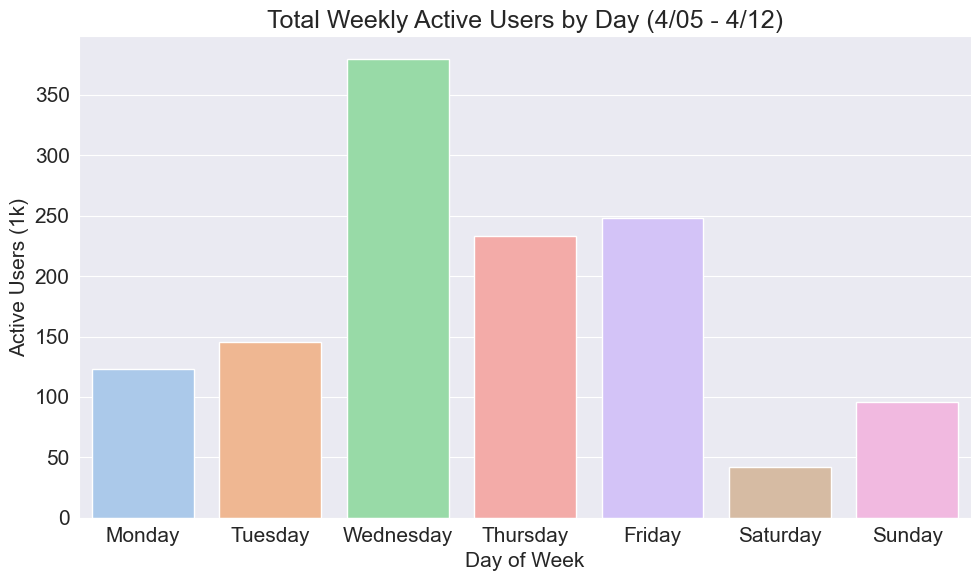

In [447]:
plt.figure(figsize=(10,6), tight_layout=True)

ax = sns.barplot(x=weekactives.index,y='Total Active Users',data=weekactives)
ax.set(title = 'Total Weekly Active Users by Day (4/05 - 4/12)', ylabel='Active Users (1k)', xlabel='Day of Week')